###  해당 커널은 다음과 같은 프로세스로 진행

1. 데이터 셋 확인
    * 데이터가 어떻게 구성되어 있는지 확인
    * 대부분의 캐글 데이터들은 잘 정제되어 있지만 실제 데이터는 아닐 가능성이 농후
      
    하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정
2. 탐색적 데이터 분석 (EDA, Exploratory Data Analysis)
    * 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인
      
    여러 시각화 툴을 사용하여 insight를 획득
3. 특성 공학 (Feature Engineering)
    * 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 한다.
      
    one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리
4. 모델 개발 및 학습
    * sklearn, keras 을 사용해 모델을 만든다.
    * 파이썬에서 머신러닝을 할 때는 sklearn 을 사용하면 수많은 알고리즘을 일관된 문법으로 사용 가능
    * 또 keras는 딥러닝 개발할 때 모델에 집중할 수 있도록 도움.
    * 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용 가능.
5. 모델 예측 및 평가
    * Train set 을 가지고 모델을 학습시킨 후, Test set 을 가지고 prediction 진행.
   
    그리고 예측 성능이 원하는 수준인지 판단 / 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다.

In [1]:
from scipy.stats import norm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import os
import joblib
import configparser


## ignore warnings
import warnings
warnings.filterwarnings('ignore')

## matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 
## 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편하다.
plt.style.use('ggplot')
sns.set_theme(font_scale=1.3) 


import missingno as msno
%matplotlib inline

##### 1. 데이터셋 확인

In [2]:
class Data_Preprocess:
    """
    class: Data_preprocess for ML
    1) Based on config file, server, ID, password, DB, case
    """
   
    ### 초기화 및 config 파일 읽어오기.
    def __init__(self, case):
        config = configparser.ConfigParser()
        config.read('AOP_config.cfg')
        
        self.server = config["server address"]["address"]
        self.ID = config["username"]["ID"]
        self.password = config["password"]["PW"]
        self.list_DBs = config["database"]["name"].split(',')
        self.export_DB = config["export database"]["name"]
        self.case = case
        
            
    ### MS-SQL로부터 데이터 가져오기.
    def _sql_get(self):
        print(self.server)
        if self.case == 'model_fit':
            sel_database = self.list_DBs
            
        else:
            sel_database = [self.export_DB]
        print(sel_database)
            
        list_df = []
        for database in sel_database:
            print('---------------')
            print('connect:', database)
            conn = pyodbc.connect(f'DRIVER={{SQL Server}};'
                                  f'SERVER={self.server};'
                                  f'DATABASE={database};'
                                  f'UID={self.ID};'
                                  f'PWD={self.password}')
                
            query = f'''
                        SELECT
                        a.[temperatureId]
                        ,a.[probeId]
                        ,a.[tempSSId]
                        ,a.[measDate]
                        ,a.[measSetNum]
                        ,a.[roomTempC]
                        ,a.[pulseVoltage]
                        ,a.[temperatureC]
                        ,a.[numTxCycles]
                        ,a.[numTxElements]
                        ,a.[txFrequencyHz]
                        ,a.[elevAperIndex]
                        ,a.[isTxAperModulationEn]
                        ,a.[txpgWaveformStyle]
                        ,a.[pulseRepetRate]
                        ,a.[scanRange]
                        ,b.[probeName]
                        ,b.[probePitchCm]
                        ,b.[probeRadiusCm]
                        ,b.[probeElevAperCm0]
                        ,b.[probeElevAperCm1]
                        ,b.[probeNumElements]
                        ,b.[probeElevFocusRangCm] 
                        ,b.[probeDescription]
                        FROM temperature AS a
                        LEFT JOIN probe_geo AS b
                            ON a.[probeId] = b.[probeId]
                        where (a.probeId < 99999999 and a.probeId > 100) and (a.measSetNum = 3 or a.measSetNum = 4)  
                        ORDER BY 1
                        '''
                    
            Raw_data = pd.read_sql_query(sql=query, con = conn)
            Raw_data.insert(0, "Database", f'{database}', True) ## allow_duplicate(중복 삽입 허용) True 설정
            
            print('Data 갯수:', len(Raw_data.index))
            list_df.append(Raw_data)
    
        AOP_data = pd.concat(list_df)
        
        ## 누락된 데이터 삭제 -> probeNumElements를 기준으로 데이터가 누락되어 있으면 전체 열을 삭제.
        AOP_data = AOP_data.dropna(subset=['probeNumElements'])
        
        return AOP_data

In [3]:
if __name__ == '__main__':
    DPP = Data_Preprocess(case='model_fit')
    AOP_data = DPP._sql_get()

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
---------------
connect: Griffin_r01
Data 갯수: 3149
---------------
connect: Frosk_r03
Data 갯수: 875
---------------
connect: New_Trees
Data 갯수: 417
---------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
---------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
---------------
connect: FROSK_r02_new
Data 갯수: 118


---
### 2. 탐색적 데이터 분석(EDA)
   #### 1) 데이터 확인
   - Printing first 5 rows of the train dataset.

In [4]:
AOP_data.head()

,Database,temperatureId,probeId,tempSSId,measDate,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,...,pulseRepetRate,scanRange,probeName,probePitchCm,probeRadiusCm,probeElevAperCm0,probeElevAperCm1,probeNumElements,probeElevFocusRangCm,probeDescription
0,Griffin_r01,325,11268278,147,2016-08-10,4,22.299999,34.899807,34.000000,2.0,...,2687.000000,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
1,Griffin_r01,327,11268278,147,2016-08-10,4,22.400000,44.226025,35.099998,2.0,...,1810.520020,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
2,Griffin_r01,329,11268278,147,2016-08-10,4,22.799999,56.044472,36.299999,2.0,...,1219.949951,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
3,Griffin_r01,332,11268278,147,2016-08-10,4,23.000000,71.021141,37.599998,2.0,...,822.010010,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
4,Griffin_r01,334,11268278,147,2016-08-10,4,23.100000,90.000000,38.799999,2.0,...,553.880005,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex


In [5]:
## AOP_data 데이터프레임 파라미터 확인.
AOP_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 0 to 117
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Database              5881 non-null   object        
 1   temperatureId         5881 non-null   int64         
 2   probeId               5881 non-null   int64         
 3   tempSSId              5881 non-null   int64         
 4   measDate              5881 non-null   datetime64[ns]
 5   measSetNum            5881 non-null   int64         
 6   roomTempC             5881 non-null   float64       
 7   pulseVoltage          5881 non-null   float64       
 8   temperatureC          5881 non-null   float64       
 9   numTxCycles           5881 non-null   float64       
 10  numTxElements         5881 non-null   int64         
 11  txFrequencyHz         5881 non-null   float64       
 12  elevAperIndex         5881 non-null   int64         
 13  isTxAperModulationEn  58

---
#### 2) Null 데이터 확인

In [6]:
print(AOP_data.isnull().sum())

## 백분율로 변환하여 display
round(AOP_data.isnull().sum()/len(AOP_data) * 100, 2)

Database                   0
temperatureId              0
probeId                    0
tempSSId                   0
measDate                   0
measSetNum                 0
roomTempC                  0
pulseVoltage               0
temperatureC               0
numTxCycles                0
numTxElements              0
txFrequencyHz              0
elevAperIndex              0
isTxAperModulationEn       0
txpgWaveformStyle          0
pulseRepetRate             0
scanRange                  0
probeName                  0
probePitchCm               0
probeRadiusCm            830
probeElevAperCm0           0
probeElevAperCm1        5881
probeNumElements           0
probeElevFocusRangCm       0
probeDescription           0
dtype: int64


Database                  0.00
temperatureId             0.00
probeId                   0.00
tempSSId                  0.00
measDate                  0.00
measSetNum                0.00
roomTempC                 0.00
pulseVoltage              0.00
temperatureC              0.00
numTxCycles               0.00
numTxElements             0.00
txFrequencyHz             0.00
elevAperIndex             0.00
isTxAperModulationEn      0.00
txpgWaveformStyle         0.00
pulseRepetRate            0.00
scanRange                 0.00
probeName                 0.00
probePitchCm              0.00
probeRadiusCm            14.11
probeElevAperCm0          0.00
probeElevAperCm1        100.00
probeNumElements          0.00
probeElevFocusRangCm      0.00
probeDescription          0.00
dtype: float64

---
- Null data 시각화
    - probeRadiusCm / probeEleAperCm1** 누락 데이터 발견 및 앞으로 해당 parameter 어떻게 할 지 계획  

<Axes: >

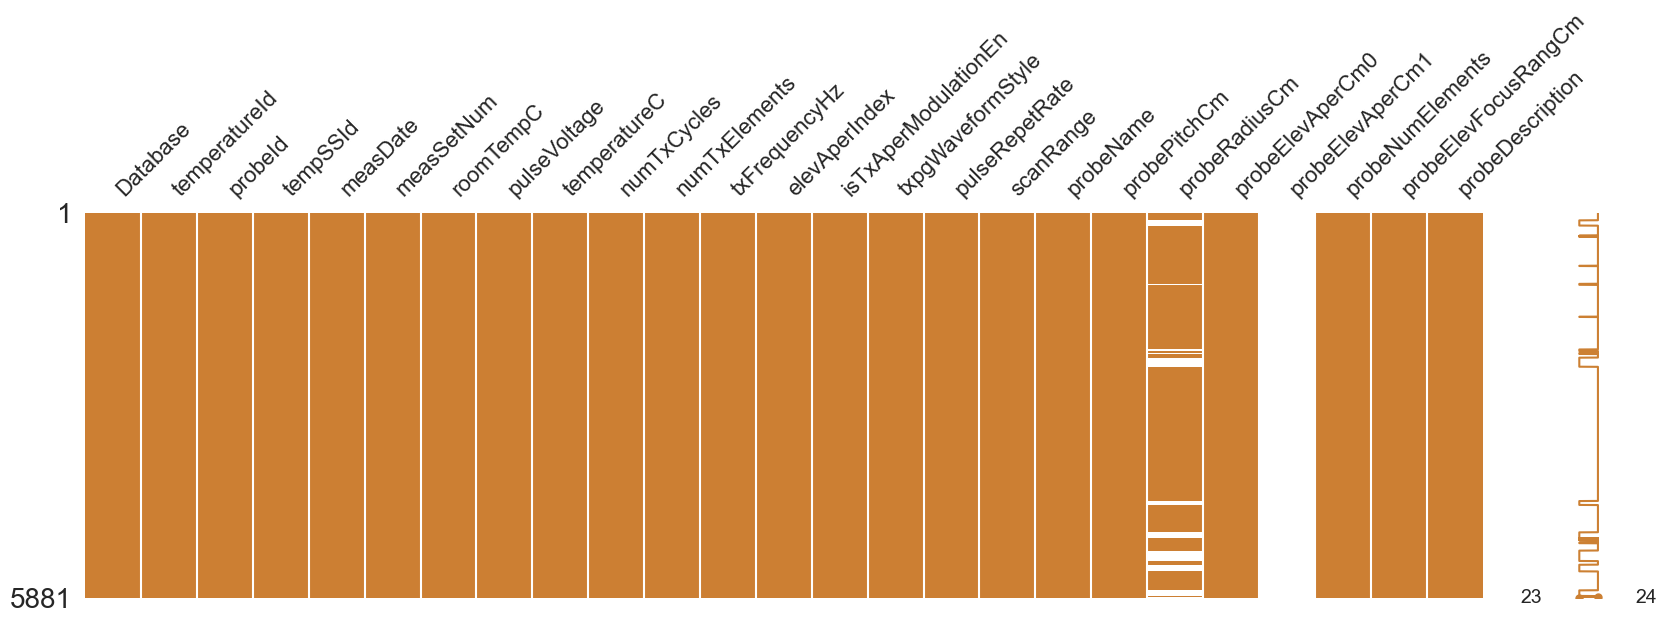

In [7]:
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### 3) 데이터 parameter 전략을 어떻게 가지고 갈 것 인지?
- a) probeRadiusCm [NULL] 데이터 --> [0]으로 변경
- b) probeElevAperCm1 컬럼 데이터 전부 삭제 --> 전부 NULL 데이터이기에 삭제
- c) probeDescription 명확하게 구분화
      - Curved, Convex, Linear, Phased
- d) measDate는 필요없어 보임
- e) probeName 역시 필요없어 보임 --> probeId로 대체
- f) Target 데이터에 대한 고민이 필요해 보임.
      - temperatureC
      - roomTempC

---
#### a) probeRadiusCm: [NULL] 데이터는 0으로 변경

<Axes: >

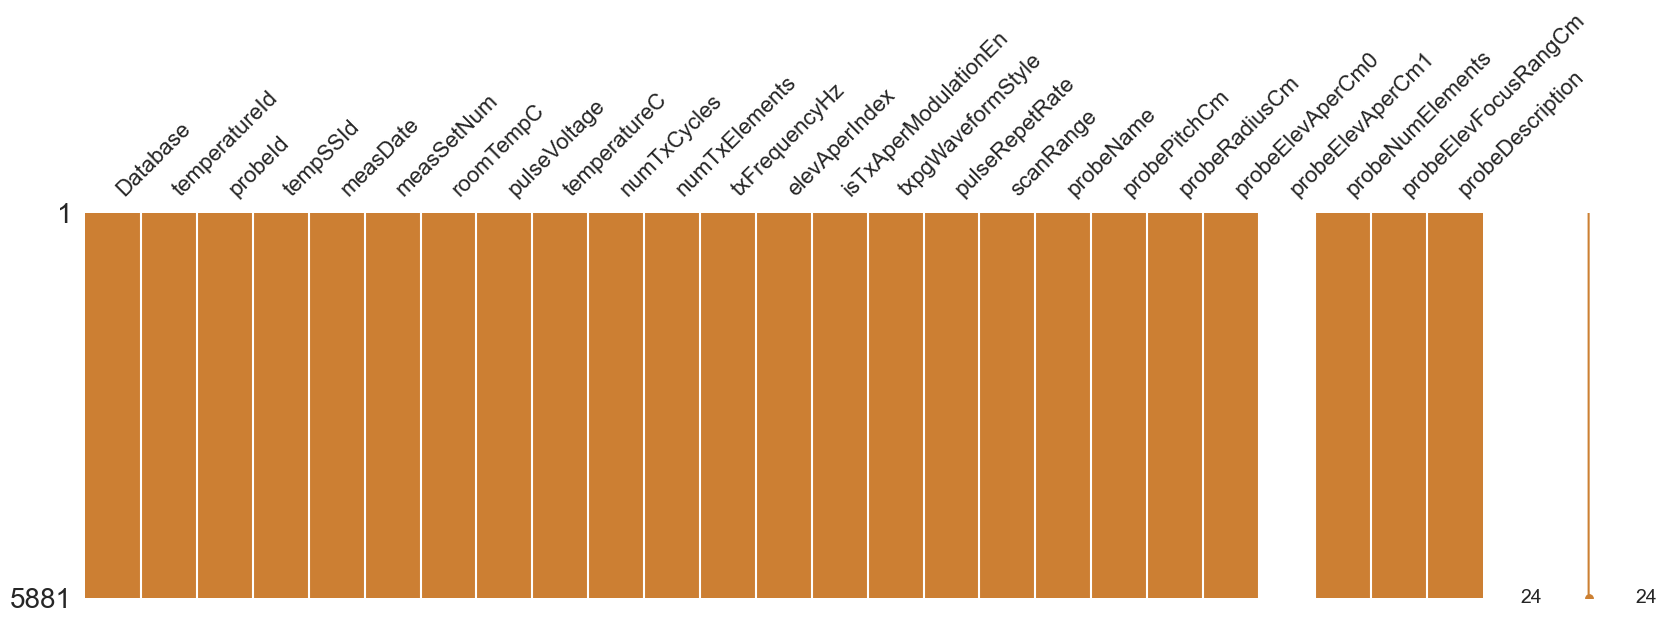

In [8]:
AOP_data['probeRadiusCm'].fillna(0, inplace=True)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### b) Drop(All NULL 데이터) --> probeElevAperCm1

<Axes: >

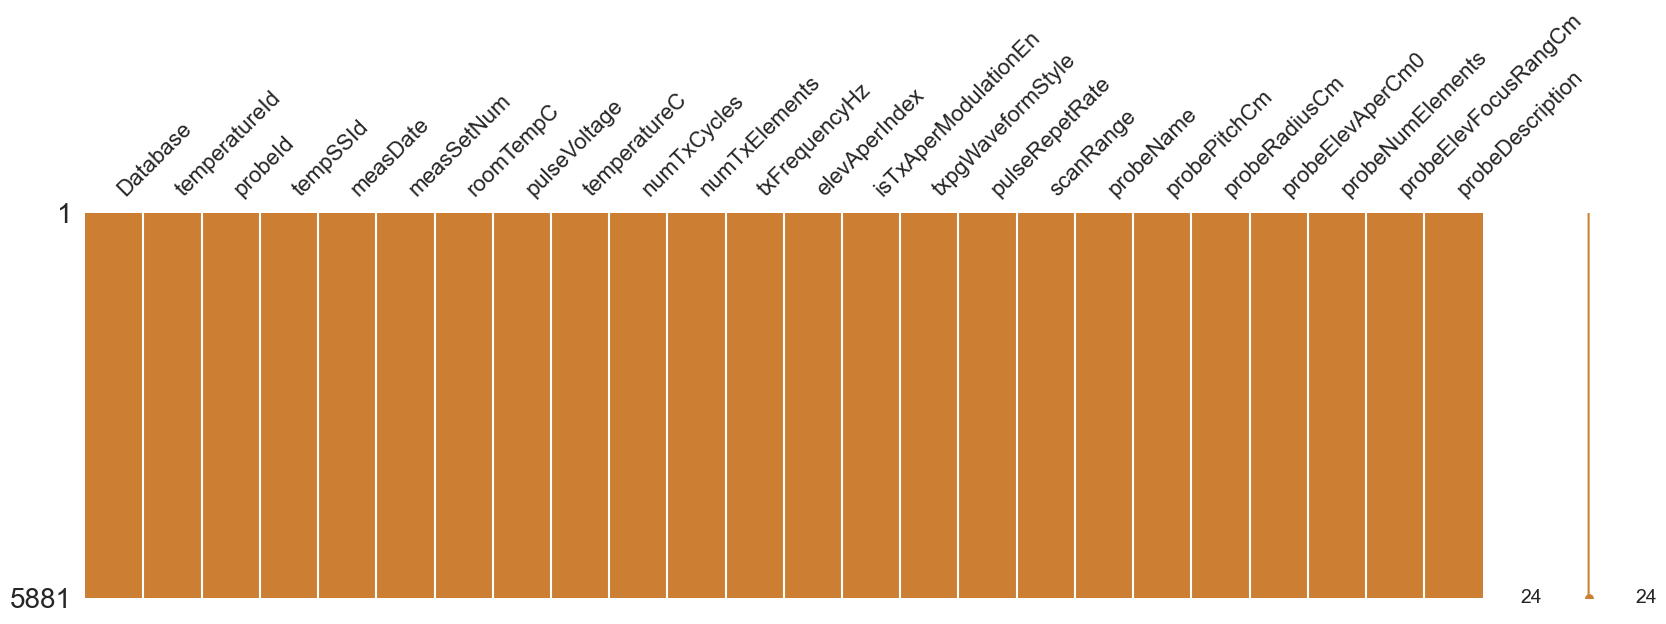

In [9]:
AOP_data = AOP_data.drop('probeElevAperCm1', axis=1)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### c) probeDescription 구분을 명확하게

In [10]:
# 열의 데이터 종류 및 갯수 확인
column_name = 'probeDescription'  # 확인하고자 하는 열의 이름
unique_values = AOP_data[column_name].unique()
value_counts = AOP_data[column_name].value_counts()

print(f"{column_name} 열의 데이터 종류: {unique_values}")
print(f"{column_name} 열의 각 데이터 갯수:\n{value_counts}")

probeDescription 열의 데이터 종류: ['Convex' 'Phased' 'Curved' 'Linear' 'AcuNav_Phased' 'Phase']
probeDescription 열의 각 데이터 갯수:
probeDescription
Convex           1809
Linear           1578
Curved           1177
Phased           1044
Phase             169
AcuNav_Phased     104
Name: count, dtype: int64


In [11]:
AOP_data.loc[AOP_data["probeDescription"] == "Curved", "probeDescription"] = "Convex"
AOP_data.loc[AOP_data["probeDescription"] == "Phased", "probeDescription"] = "Phase"
AOP_data.loc[AOP_data["probeDescription"] == "AcuNav_Phased", "probeDescription"] = "Phase"

# 열의 데이터 종류 및 갯수 확인
column_name = 'probeDescription'  # 확인하고자 하는 열의 이름
unique_values = AOP_data[column_name].unique()
value_counts = AOP_data[column_name].value_counts()

print(f"{column_name} 열의 데이터 종류: {unique_values}")
print(f"{column_name} 열의 각 데이터 갯수:\n{value_counts}")
print(len(AOP_data[column_name]))

probeDescription 열의 데이터 종류: ['Convex' 'Phase' 'Linear']
probeDescription 열의 각 데이터 갯수:
probeDescription
Convex    2986
Linear    1578
Phase     1317
Name: count, dtype: int64
5881


---
#### d)-e) measDate / probeName 필요없어서 Drop

<Axes: >

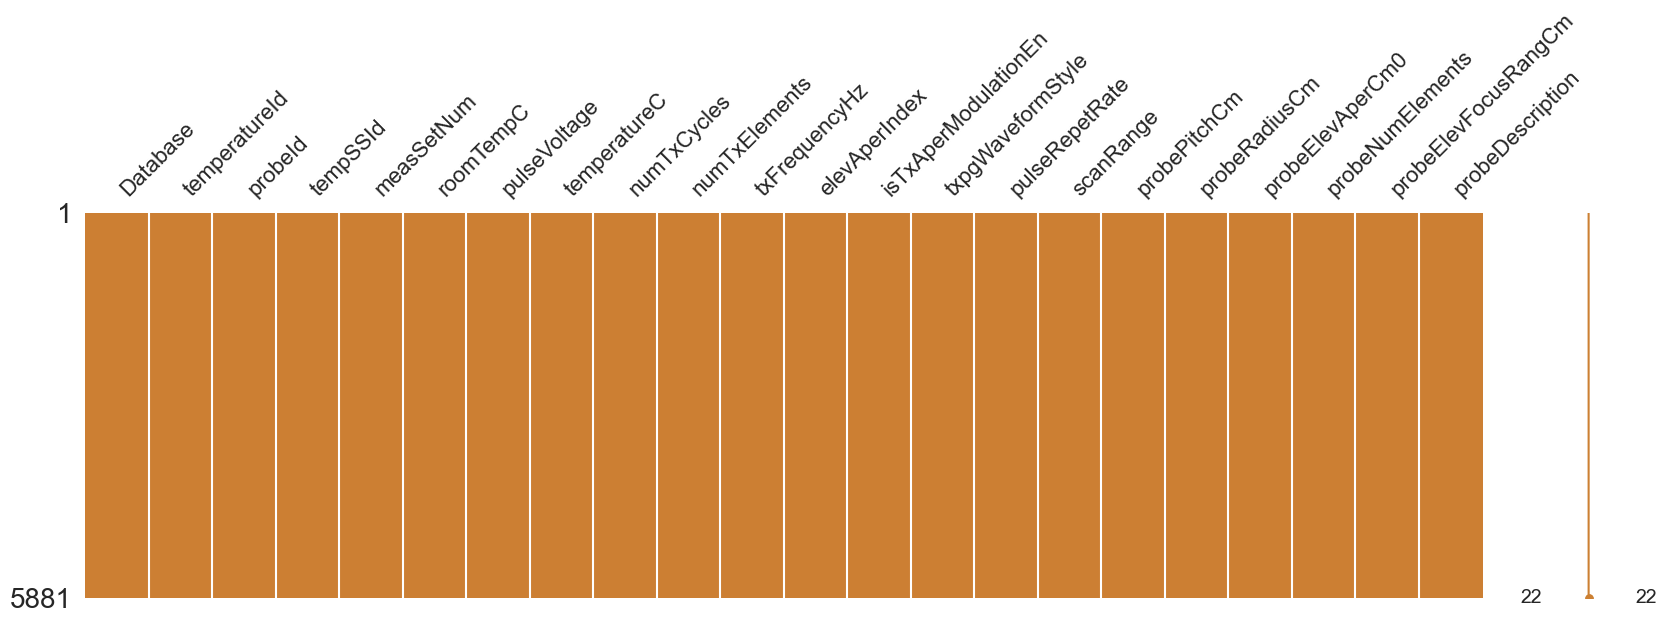

In [12]:
AOP_data = AOP_data.drop(["measDate", "probeName"], axis=1)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### f) Target 데이터 분석

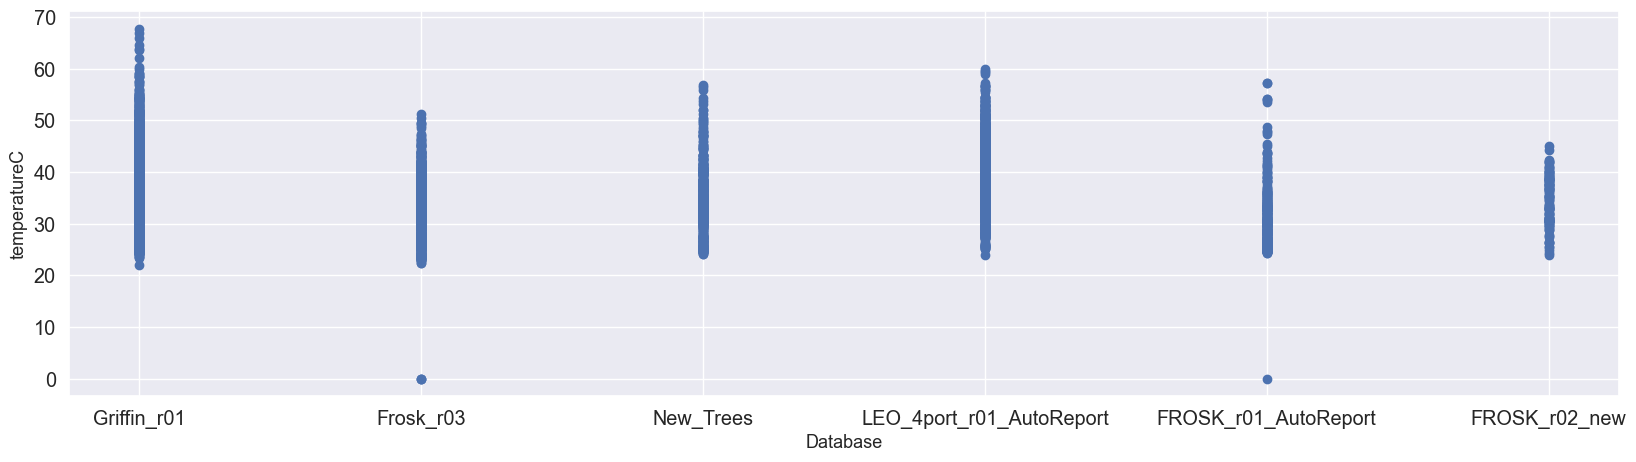

In [13]:
fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x = AOP_data['Database'], y = AOP_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

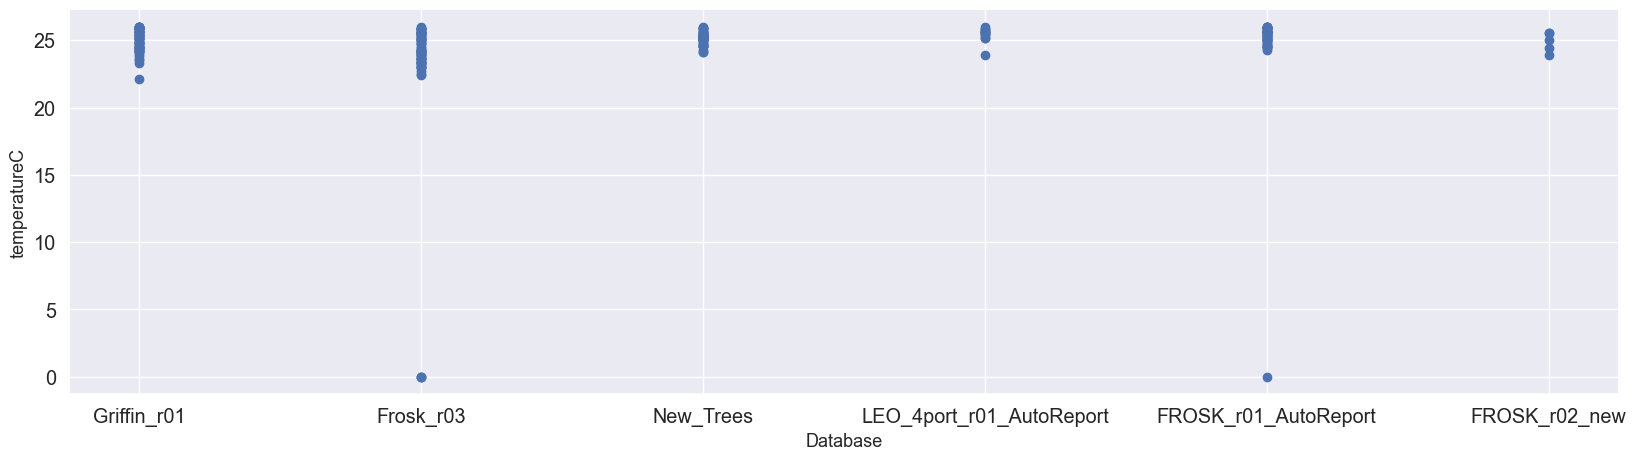

In [14]:
# temperatureC가 26도 이하인 데이터만 필터링
filtered_data = AOP_data[AOP_data['temperatureC'] <= 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=filtered_data['Database'], y=filtered_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

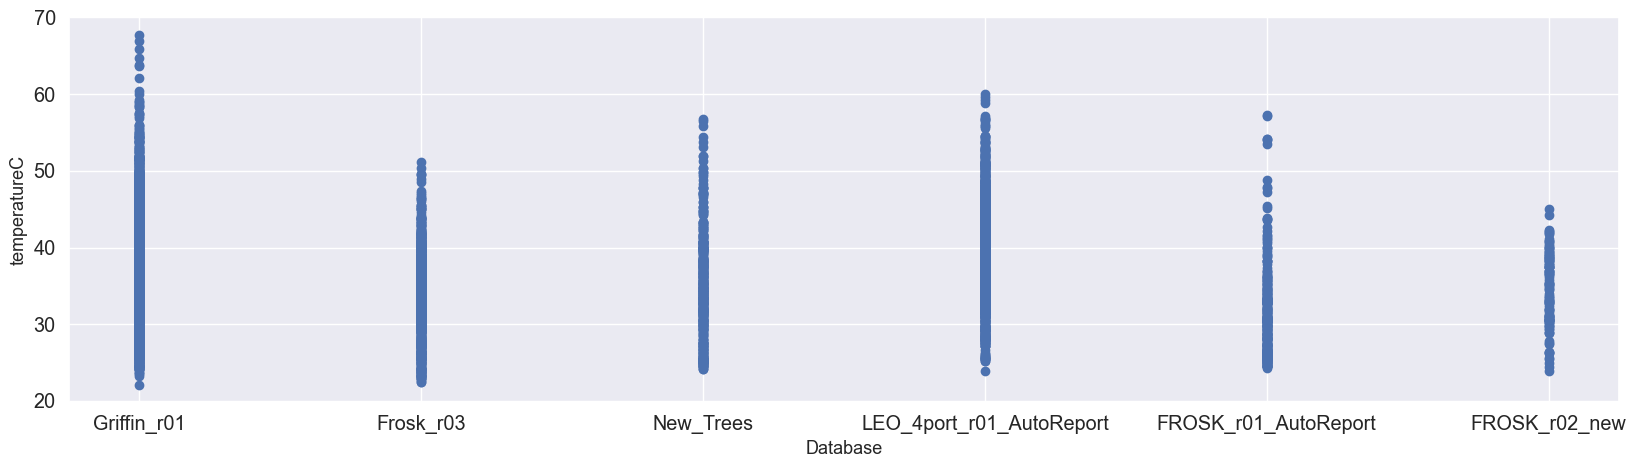

In [15]:
# temperatureC가 0인 행 삭제
AOP_data = AOP_data[AOP_data['temperatureC'] > 20]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=AOP_data['Database'], y=AOP_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

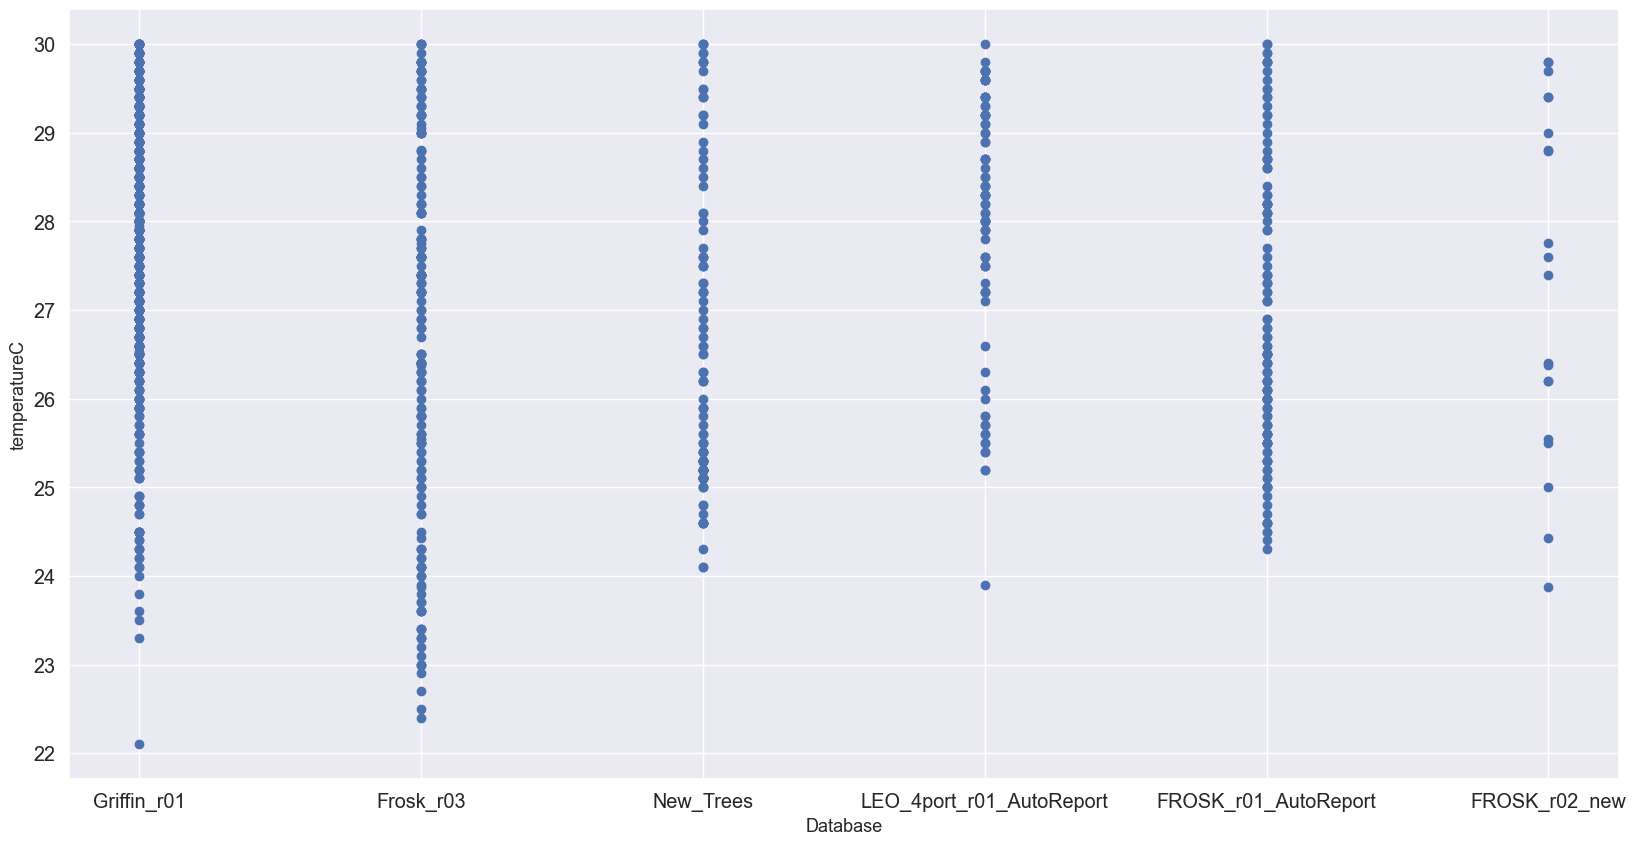

In [16]:
# temperatureC가 26도 이하인 데이터만 필터링
filtered_data = AOP_data[AOP_data['temperatureC'] <= 30]

fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x=filtered_data['Database'], y=filtered_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

---
#### f) Target 데이터의 분석
- temperatureC - roomTempC 분석
- histogram이용하여 분석
- Skewness / 왜도
    - symmetrical bell curve 혹은 normal distribution에서 왜곡 정도를 말한다. 데이터 분포의 대칭성이 얼마나 결핍되었는지를 측정한다. 완전히 대칭인 분포는 skewness가 0이다.
    - 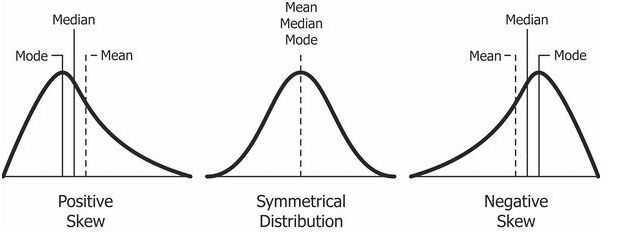

---
#### 확률 및 분포

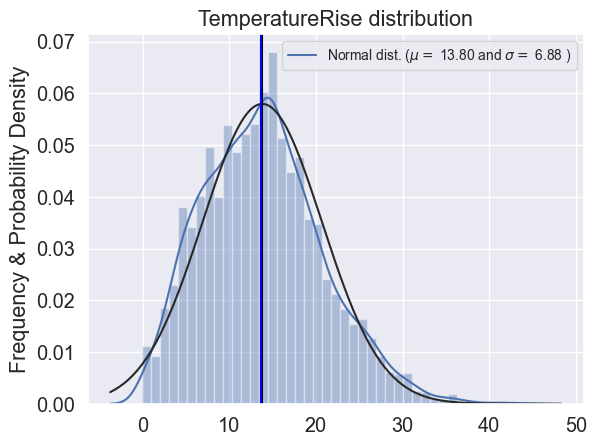

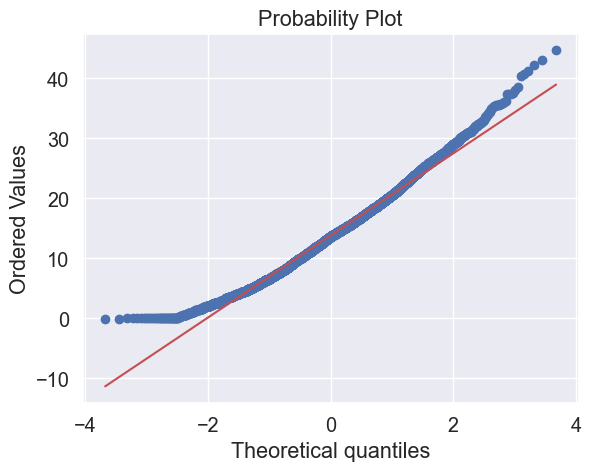

Skewness & TempRise: 0.448072
Kurtosis & TempRise: 0.111110


In [17]:
TemperatureRise = (AOP_data['temperatureC'] - AOP_data['roomTempC'])

sns.distplot(TemperatureRise , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(TemperatureRise)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Frequency & Probability Density')
plt.title('TemperatureRise distribution')

## TemperatureRise mean and median value display
plt.axvline(TemperatureRise.mean(), color='black')
plt.axvline(TemperatureRise.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(TemperatureRise, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & TempRise: %f" % TemperatureRise.skew())
print("Kurtosis & TempRise: %f" % TemperatureRise.kurt())

---
#### Temperature 분석

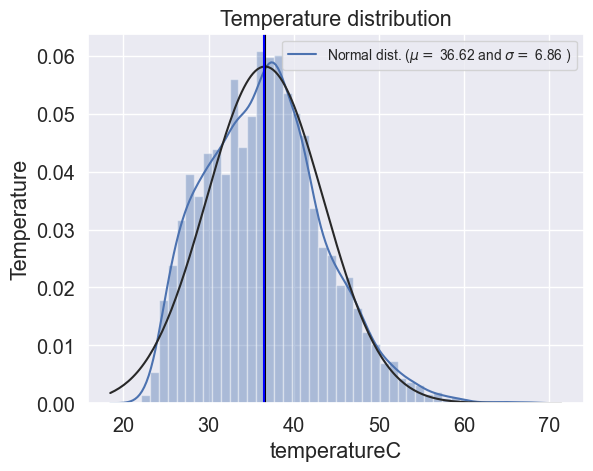

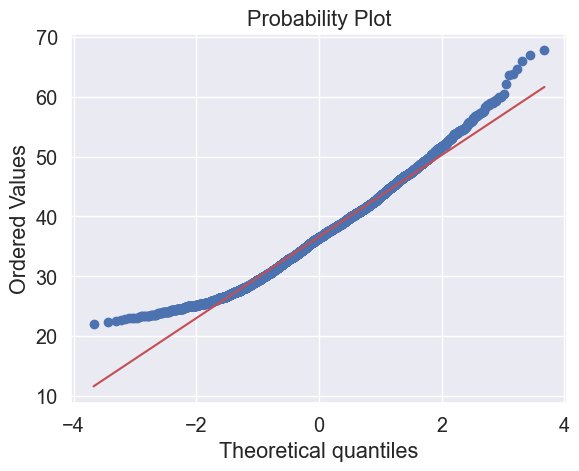

Skewness & Temp: 0.442764
Kurtosis & Temp: 0.095745


In [18]:
Temperature = (AOP_data['temperatureC'])

sns.distplot(Temperature , fit=norm);

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Temperature)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Temperature')
plt.title('Temperature distribution')

## Temperature mean and median value display
plt.axvline(Temperature.mean(), color='black')
plt.axvline(Temperature.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Temperature, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % Temperature.skew())
print("Kurtosis & Temp: %f" % Temperature.kurt())

---
#### log transform 변환하여 확인하기(TemperatureRise)

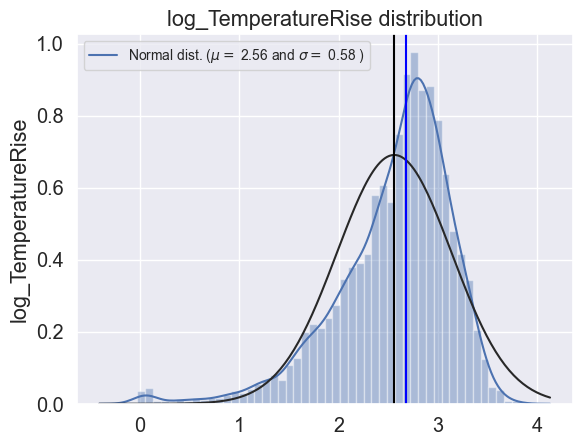

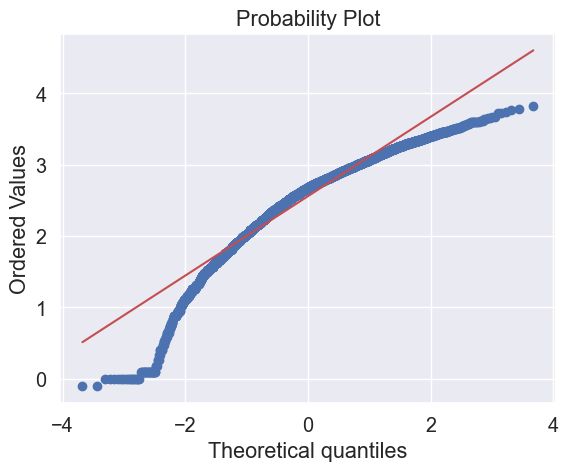

Skewness & TempRise: -1.241566
Kurtosis & TempRise: 2.459155


In [19]:
log_temp_rise = np.log1p(TemperatureRise)

sns.distplot(log_temp_rise , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp_rise)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_TemperatureRise')
plt.title('log_TemperatureRise distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp_rise.mean(), color='black')
plt.axvline(log_temp_rise.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp_rise, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & TempRise: %f" % log_temp_rise.skew())
print("Kurtosis & TempRise: %f" % log_temp_rise.kurt())

#### log transform 변환하여 확인하기(temperatureC)

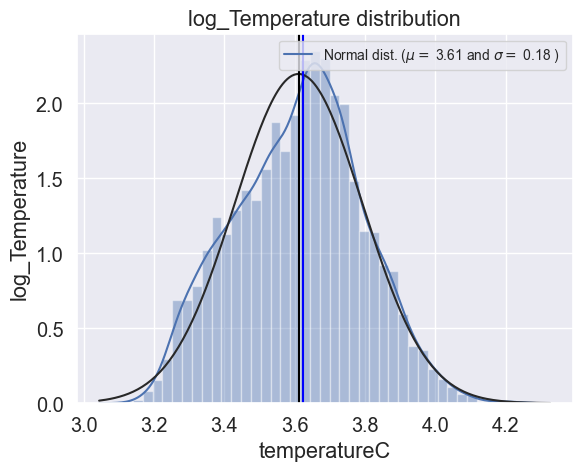

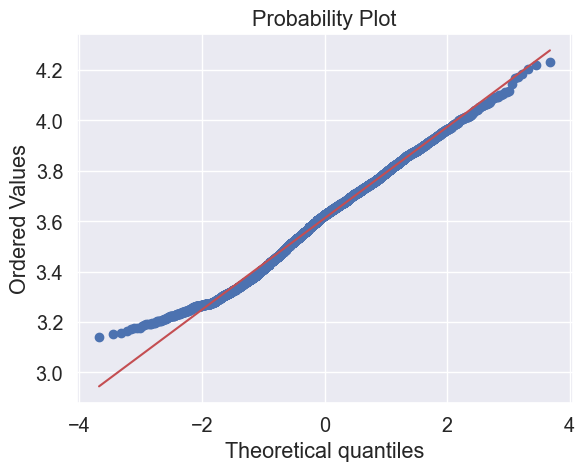

Skewness & Temp: -0.012657
Kurtosis & Temp: -0.428928


In [20]:
log_temp = np.log1p(Temperature)

sns.distplot(log_temp , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_Temperature')
plt.title('log_Temperature distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp.mean(), color='black')
plt.axvline(log_temp.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % log_temp.skew())
print("Kurtosis & Temp: %f" % log_temp.kurt())

#### Relationship with numerical variables

##### Targer vs. pulseRepetRate

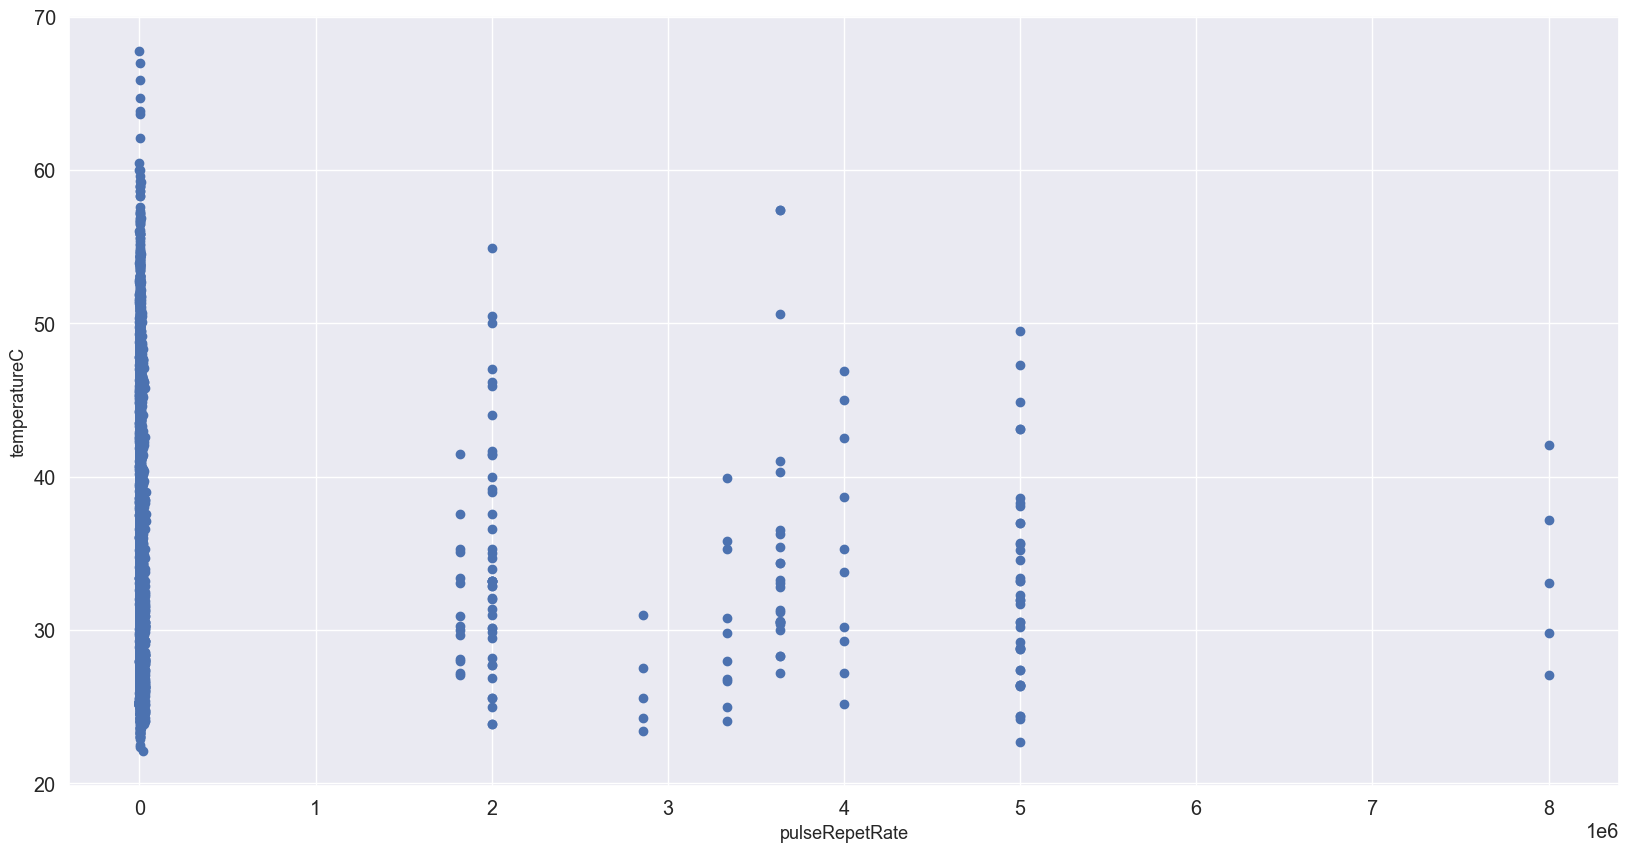

In [21]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseRepetRate'], y = AOP_data['temperatureC'])
plt.xlabel('pulseRepetRate', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

In [22]:
print(AOP_data['pulseRepetRate'].unique())
print(AOP_data['pulseRepetRate'].value_counts())
print('pulseRepetRate 종류 갯수:', AOP_data['pulseRepetRate'].nunique())
print('-----')

over_1MHz = AOP_data[AOP_data['pulseRepetRate']>1000000]
print(over_1MHz['pulseRepetRate'].value_counts())

[2687.         1810.52001953 1219.94995117 ... 1505.69995117 5387.93017578
 3434.07006836]
pulseRepetRate
3.000000e+04    77
2.000000e+06    43
5.000000e+06    40
4.000000e+03    31
5.000000e+03    29
                ..
5.223000e+03     1
2.951610e+03     1
1.668010e+03     1
9.426200e+02     1
3.434070e+03     1
Name: count, Length: 3709, dtype: int64
pulseRepetRate 종류 갯수: 3709
-----
pulseRepetRate
2000000.0    43
5000000.0    40
3636400.0    24
1818200.0    14
3333300.0    10
4000000.0    10
8000000.0     5
2857100.0     5
Name: count, dtype: int64


##### CW관련 데이터 삭제(pulseRepetRate > 1000000)

In [23]:
# pulseRepetRate 1000000 이상일 경우, 행 삭제
AOP_data = AOP_data[AOP_data['pulseRepetRate'] < 1000000]

over_1MHz = AOP_data[AOP_data['pulseRepetRate']>1000000]
print(over_1MHz['pulseRepetRate'].value_counts())

Series([], Name: count, dtype: int64)


##### Target vs. NumTxCycles

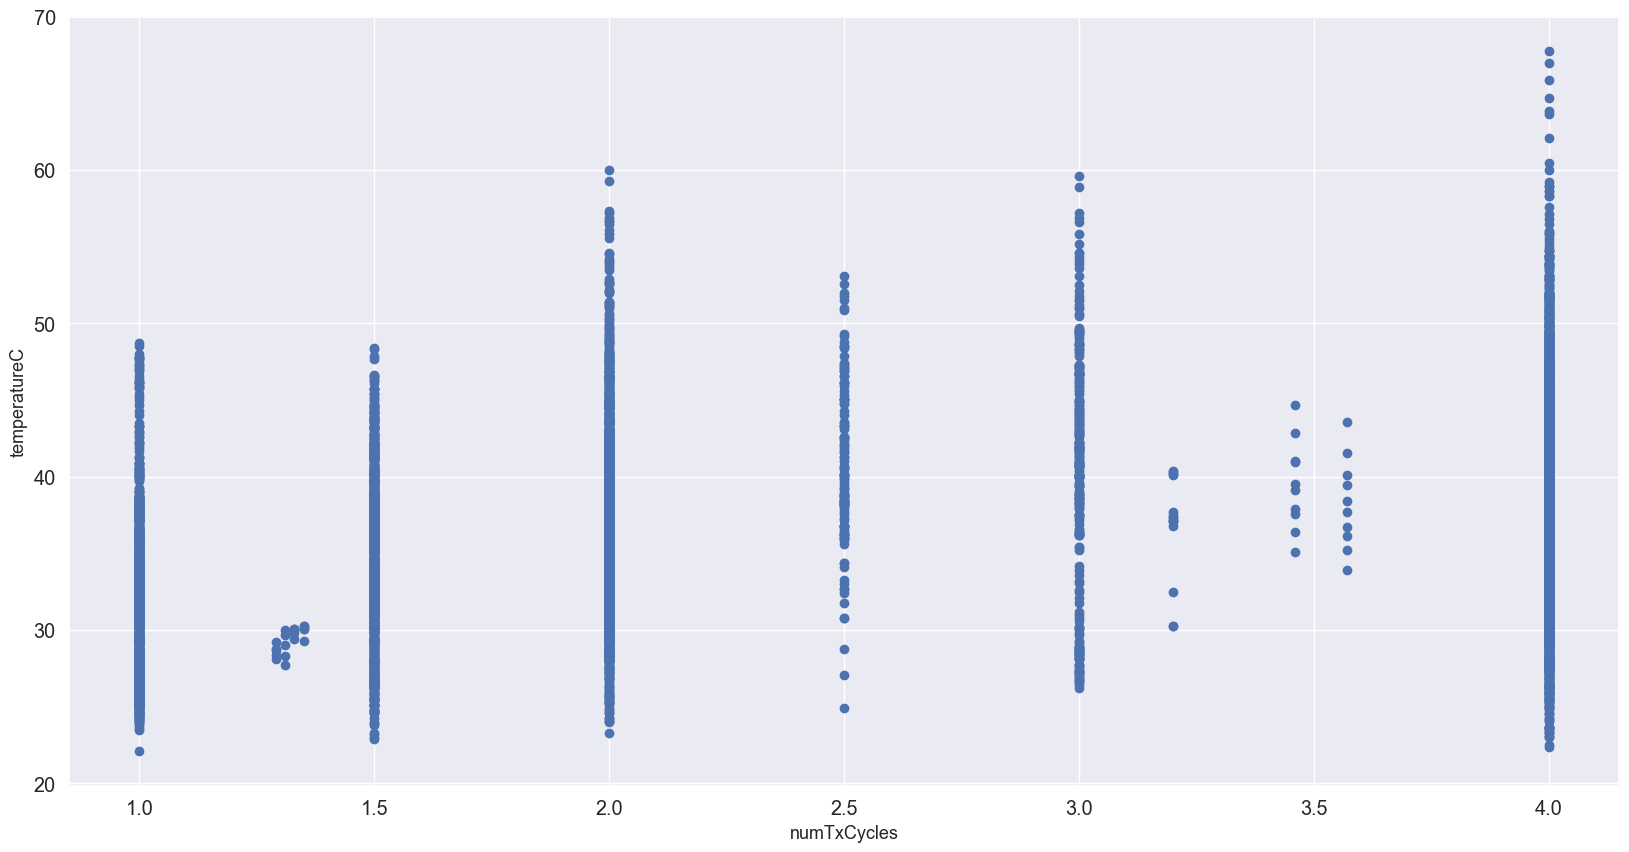

In [24]:
fig, axs = plt.subplots(figsize=(20,10))
axs.scatter(x = AOP_data['numTxCycles'], y = AOP_data['temperatureC'])
plt.xlabel('numTxCycles', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '1.0'),
  Text(1, 0, '1.2899999618530273'),
  Text(2, 0, '1.309999942779541'),
  Text(3, 0, '1.3300000429153442'),
  Text(4, 0, '1.350000023841858'),
  Text(5, 0, '1.5'),
  Text(6, 0, '2.0'),
  Text(7, 0, '2.5'),
  Text(8, 0, '3.0'),
  Text(9, 0, '3.200000047683716'),
  Text(10, 0, '3.4600000381469727'),
  Text(11, 0, '3.569999933242798'),
  Text(12, 0, '4.0')])

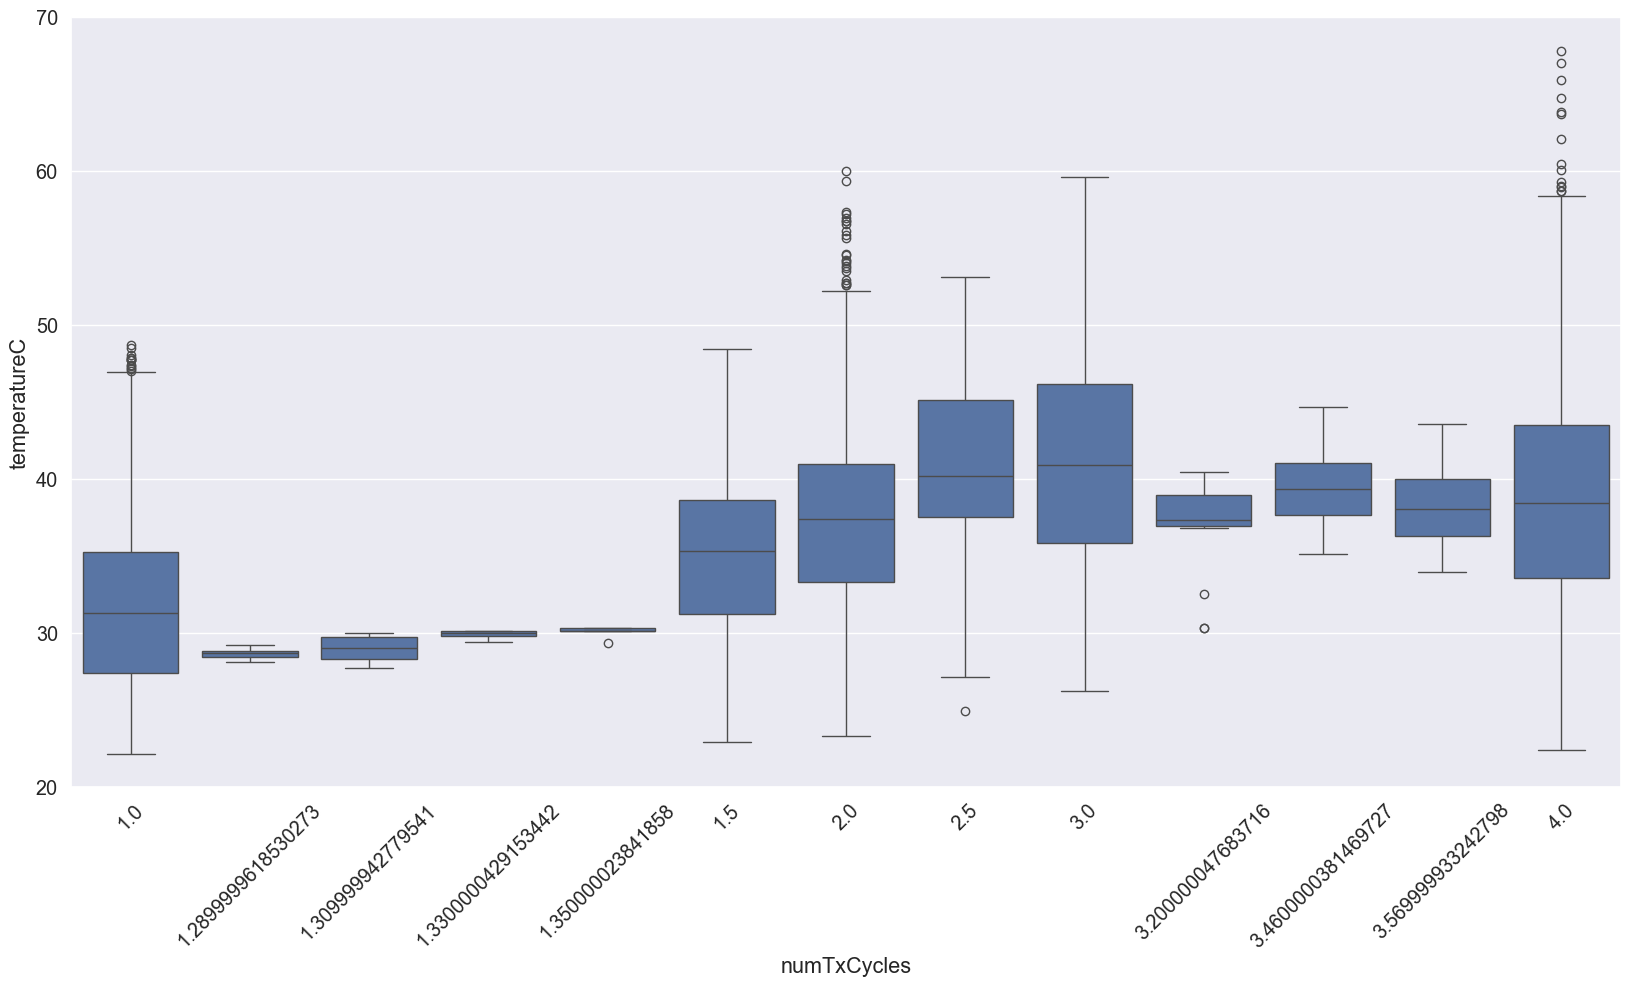

In [29]:
#box plot numTxCycles / temperatureC
var = 'numTxCycles'
data = pd.concat([AOP_data['temperatureC'], AOP_data[var]], axis=1)
fig, axs = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="temperatureC", data=data)
fig.axis(ymin=20, ymax=70)
plt.xticks(rotation=45)

##### Target vs. txFrequencyHz

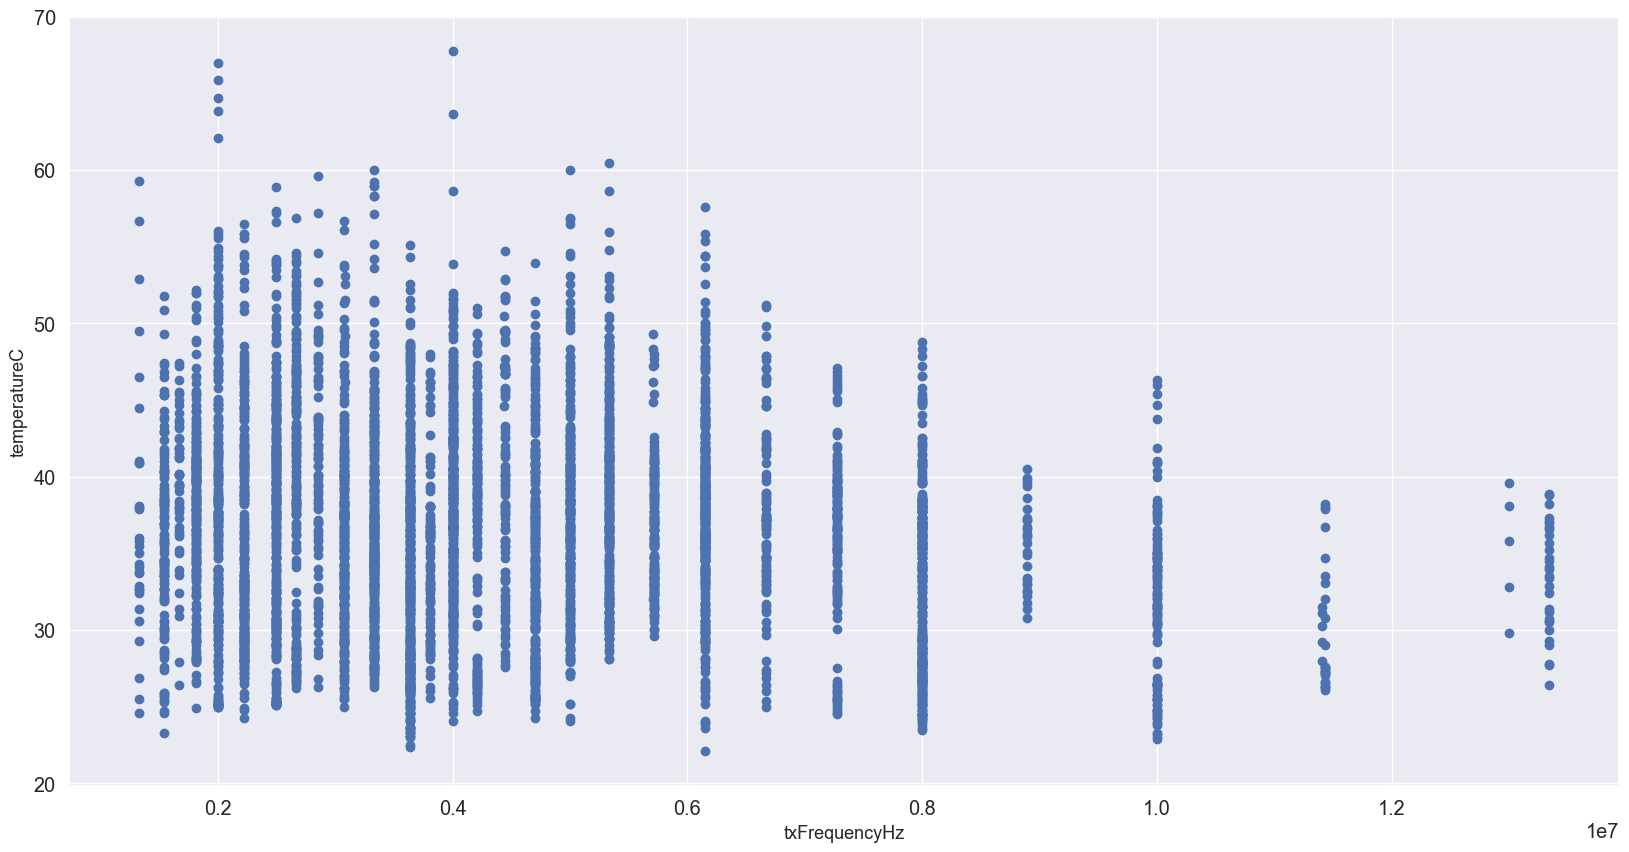

In [30]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['txFrequencyHz'], y = AOP_data['temperatureC'])
plt.xlabel('txFrequencyHz', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. voltage

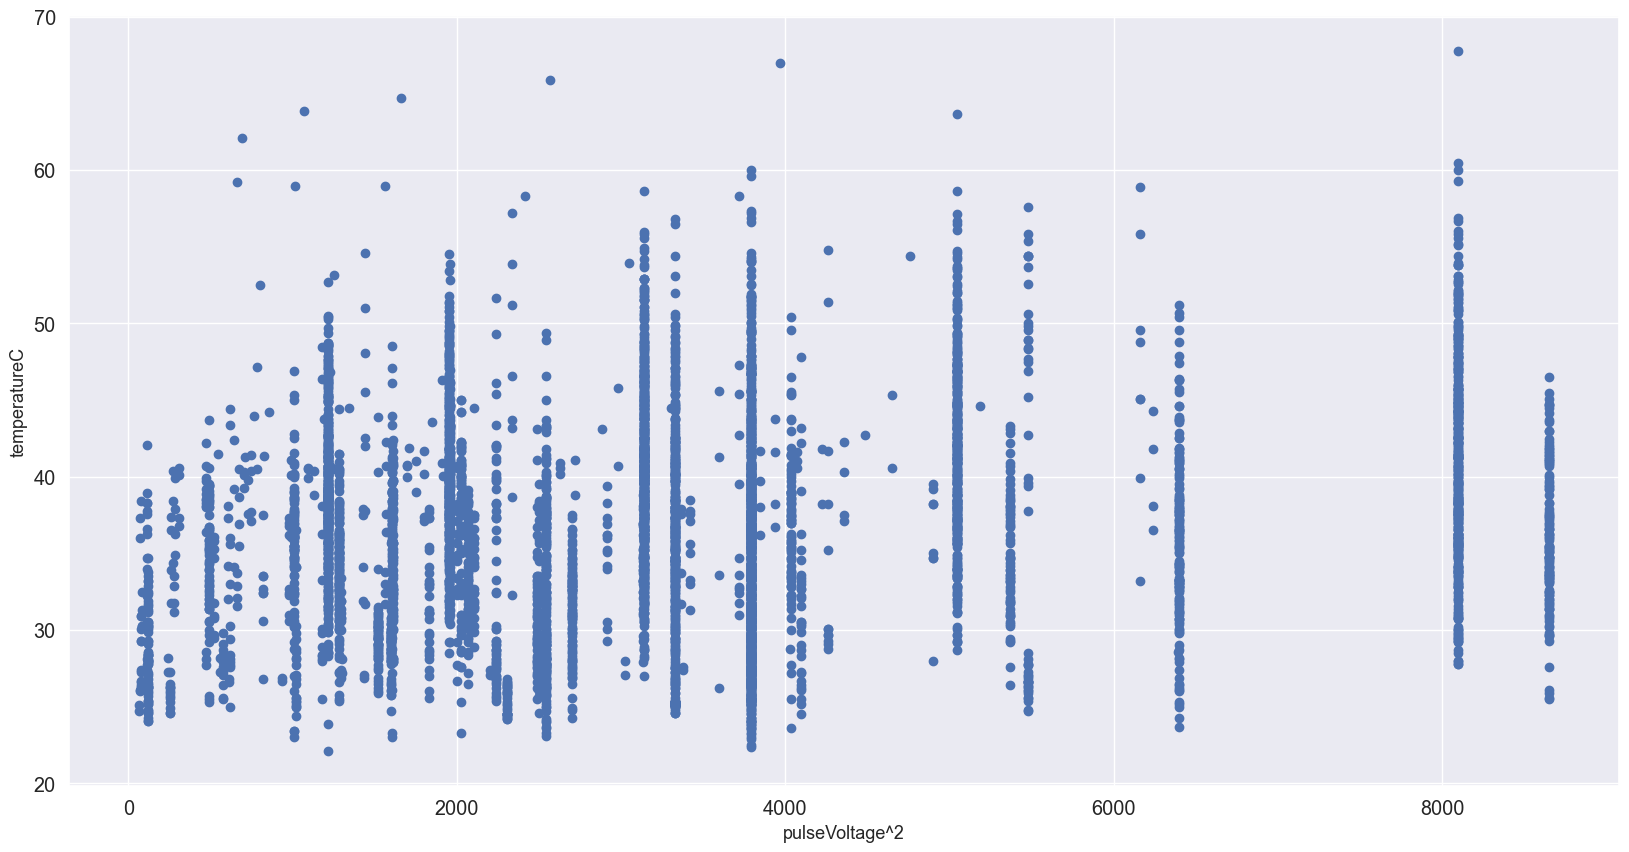

In [39]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'], y = AOP_data['temperatureC'])
plt.xlabel('pulseVoltage^2', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. Energy

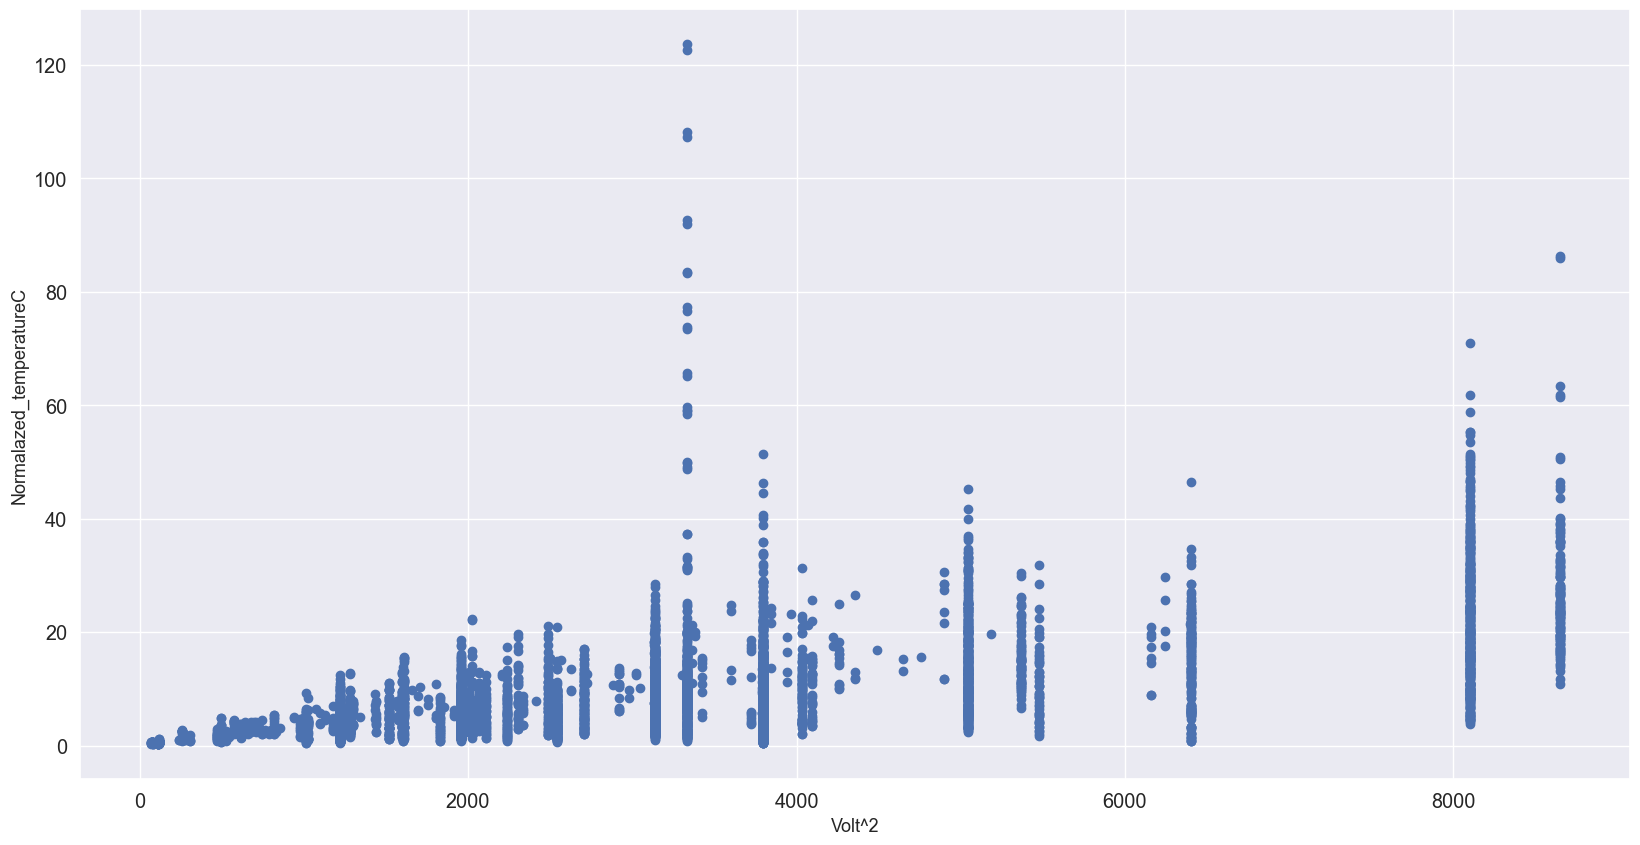

In [40]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'], 
            y = (AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

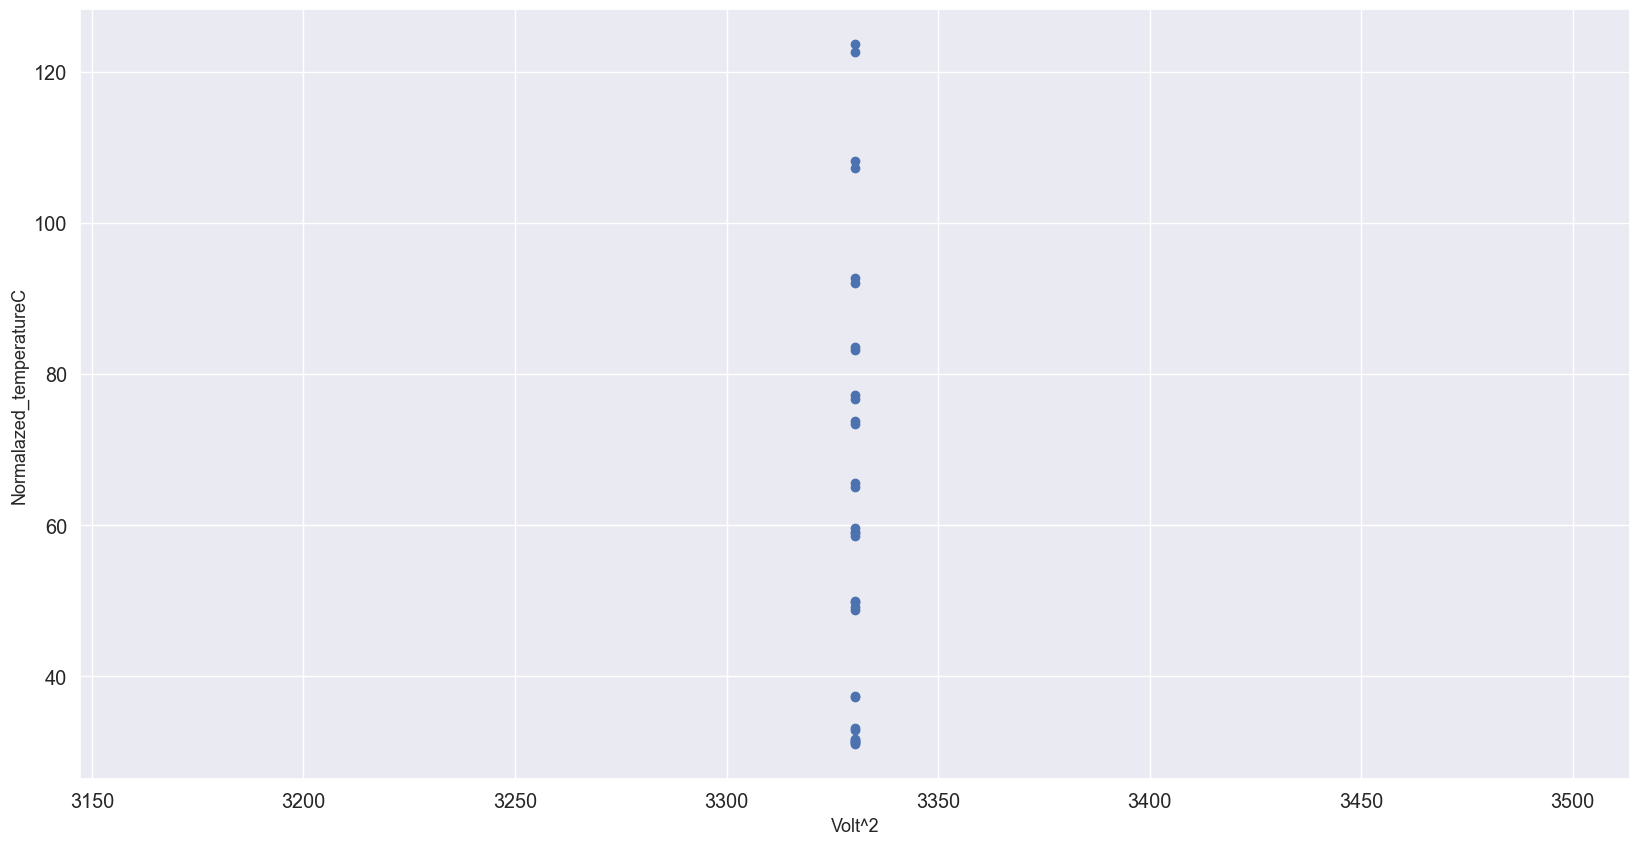

In [43]:
AOP_data['volt2'] = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage']
AOP_data['normal_Temp'] = AOP_data['temperatureC'] / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000))

outlier = AOP_data[(AOP_data['volt2'] < 3500) & (AOP_data['normal_Temp'] > 30)]

fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = outlier['volt2'], y = outlier['normal_Temp'])
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

In [49]:
print(outlier.shape)
outlier.head(32)

(32, 24)


,Database,temperatureId,probeId,tempSSId,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,numTxElements,...,pulseRepetRate,scanRange,probePitchCm,probeRadiusCm,probeElevAperCm0,probeNumElements,probeElevFocusRangCm,probeDescription,volt2,normal_Temp
148,New_Trees,293,11711157,146,4,25.000000,57.709999,25.400000,1.0,86,...,770.510010,0.000000,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,32.965178
153,New_Trees,299,11711157,147,4,25.000000,57.709999,25.600000,1.0,86,...,770.510010,0.000000,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,33.224747
155,New_Trees,302,11711157,146,3,25.000000,57.709999,25.100000,1.0,9,...,799.739990,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,31.385201
159,New_Trees,306,11711157,146,3,25.100000,57.709999,25.100000,1.0,22,...,385.450012,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,65.118691
160,New_Trees,307,11711157,146,3,25.100000,57.709999,25.100000,1.0,22,...,794.659973,2.176970,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,31.585837
163,New_Trees,310,11711157,146,3,25.100000,57.709999,25.200001,1.0,43,...,425.890015,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,59.170208
164,New_Trees,311,11711157,146,3,25.100000,57.709999,25.200001,1.0,43,...,505.660004,2.176970,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,49.835859
165,New_Trees,312,11711157,146,3,25.100000,57.709999,25.100000,1.0,43,...,674.219971,4.390120,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,37.228207
166,New_Trees,313,11711157,146,3,25.100000,57.709999,25.100000,1.0,43,...,809.059998,6.228760,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,31.023658
167,New_Trees,314,11711157,146,3,25.100000,57.709999,25.200001,1.0,64,...,302.739990,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,83.239749


In [189]:
print(AOP_data[(AOP_data['temperatureC']==0)].index)
print(AOP_data[(AOP_data['temperatureC']<26)].index)

print(len(AOP_data[(AOP_data['temperatureC']<26)].index))

# AOP_data = AOP_data.drop(AOP_data[AOP_data['temperatureC']].index)

Int64Index([793, 794, 796], dtype='int64')
Int64Index([ 586, 1055, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
            ...
             474,  476,  477,  478,  481,   56,   61,   62,  106,  107],
           dtype='int64', length=184)
184


In [190]:
## numpy로 변환하여 데이터 확인하기.
df_AOP = AOP_data[AOP_data['pulseRepetRate']>18000]
PRF_AOP = df_AOP['pulseRepetRate']
data = PRF_AOP.to_numpy()
print(np.unique(data, return_counts=True))

(array([  18053.        ,   18059.5       ,   18166.        ,
         18344.80078125,   18662.69921875,   18894.5       ,
         19091.5       ,   19437.19921875,   19500.        ,
         19503.30078125,   19531.19921875,   19600.69921875,
         19763.30078125,   20040.5       ,   20093.30078125,
         20249.80078125,   20298.69921875,   20436.        ,
         20598.        ,   20619.80078125,   20879.69921875,
         20996.69921875,   21192.69921875,   21297.19921875,
         21338.19921875,   21445.5       ,   22155.69921875,
         22428.19921875,   22513.69921875,   22642.69921875,
         23014.80078125,   23059.30078125,   23200.80078125,
         23417.19921875,   23706.5       ,   24962.19921875,
         26069.        ,   26263.69921875,   26354.5       ,
         26356.30078125,   26647.80078125,   26841.69921875,
         27227.5       ,   27352.30078125,   28606.30078125,
         29919.19921875,   30439.        ,   33262.69921875,
         33754.        

In [1]:
## Dataframe
print(round(df_AOP['pulseRepetRate']).unique())
print(df_AOP['pulseRepetRate'].value_counts())
print('pulseRepetRate 종류 갯수:', df_AOP['pulseRepetRate'].nunique())


# data = AOP_data[AOP_data['pulseRepetRate']>18000].to_numpy()
print(len(AOP_data[(AOP_data['pulseRepetRate']>18000)].index))
# print(AOP_data[(AOP_data['pulseRepetRate']>18000)])

NameError: name 'df_AOP' is not defined

##### Drop unnecessary data
- pulseRepetRate가 18000(CW-mode) 이상이거나 또는 온도가 26도 미만일 경우는 Drop.
- As below, Drop condition output test code.
    - AOP_data[(AOP_data['temperatureC']<26) | (AOP_data['pulseRepetRate']>18000)].to_csv('drop_data.csv')

In [192]:
print('Before drop unnecessary data:', AOP_data.shape)

## <Drop unnecessary data>
## pulseRepetRate가 18000(CW) 이상이거나 또는 온도가 26도 미만일 경우는 Drop.
AOP_data = AOP_data.drop(AOP_data[(AOP_data['temperatureC']<26) | (AOP_data['pulseRepetRate']>18000)].index)
print('After drop unnecessary data:', AOP_data.shape)

Before drop unnecessary data: (4822, 25)
After drop unnecessary data: (3924, 25)


##### Data Correlation
- Correlation map to see how features are correlated with TemperatureRise

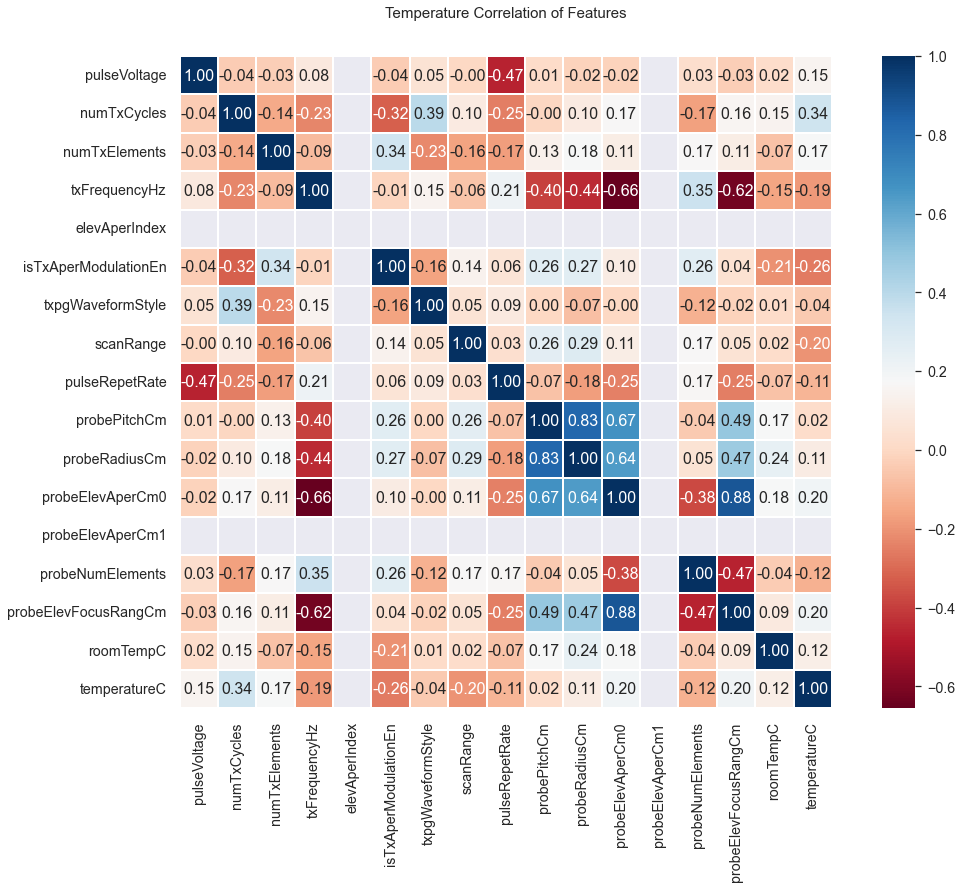

In [228]:
heatmap_data = AOP_data[['pulseVoltage', 'numTxCycles', 'numTxElements', 'txFrequencyHz', 'elevAperIndex',
                         'isTxAperModulationEn', 'txpgWaveformStyle', 'scanRange', 'pulseRepetRate', 'probePitchCm',
                         'probeRadiusCm', 'probeElevAperCm0', 'probeElevAperCm1', 'probeNumElements', 'probeElevFocusRangCm', 'roomTempC', 'temperatureC']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(18, 12))
plt.title('Temperature Correlation of Features', y=1.05, size=15)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, fmt='.2f',
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

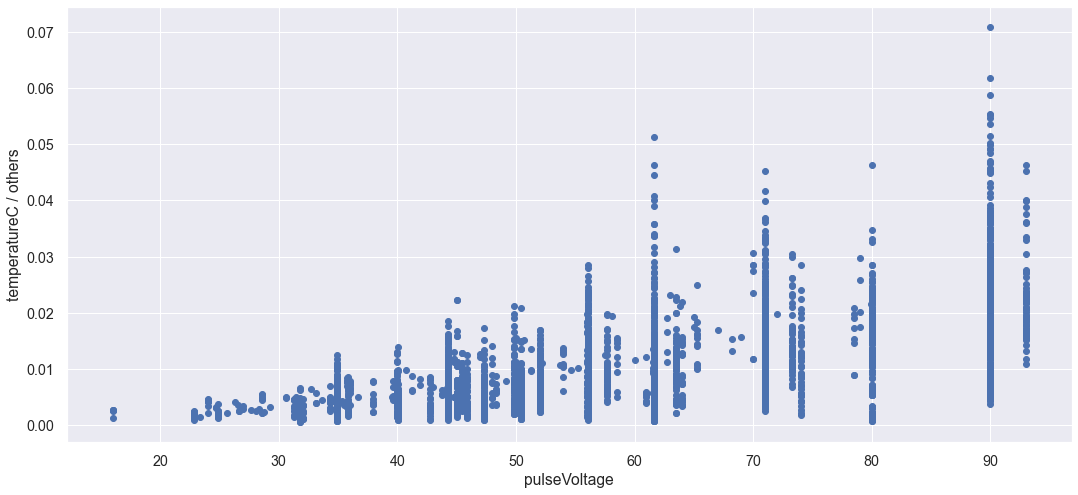

In [262]:
plt.figure(figsize=(18, 8))
plt.scatter(x = AOP_data['pulseVoltage'], y = AOP_data['temperatureC'] / (AOP_data['numTxCycles'] * AOP_data['pulseRepetRate'] ))
plt.xlabel('pulseVoltage')
plt.ylabel('temperatureC / others')
plt.show()

In [6]:
if __name__ == '__main__':
    DPP = Data_Preprocess(case='model_fit')
    AOP_data = DPP._sql_get()
    ##### in progress #####
    ## AOP_data라는 데이터가 있을 경우, SQL에서 데이터를 읽어오지 않기  

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
---------------
connect: Griffin_r01
Data 갯수: 2754
---------------
connect: Frosk_r03
Data 갯수: 875
---------------
connect: New_Trees
Data 갯수: 257
---------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
---------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
---------------
connect: FROSK_r02_new
Data 갯수: 118


In [ ]:
train_input, test_input, train_target, teat_target = train_test_split(AOP_data, )